# Load the dataset and clean it  
### Author: Francesca Naretto

In [1]:
#load the adult dataset
import pandas as pd
adult = pd.read_csv('./datasets/adult.data', delimiter=",", names=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss','hours-per-week', 'native-country', 'label'])

In [2]:
#visualize the structure of the dataset
adult.head()

age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country   label  
0          2174             0              40   United-States   <=50K  
1             0             0              13   United-States   <=50K  
2             0             0              40   United-States   <=50K  
3             0             0              40   United-States   <=50K  
4             0             0              40            Cuba   <=50K

In [3]:
#a descrption of the dataset
adult.describe()

age        fnlwgt  education-num  capital-gain  capital-loss  \
count  32561.000000  3.256100e+04   32561.000000  32561.000000  32561.000000   
mean      38.581647  1.897784e+05      10.080679   1077.648844     87.303830   
std       13.640433  1.055500e+05       2.572720   7385.292085    402.960219   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.178270e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783560e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.370510e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    32561.000000  
mean        40.437456  
std         12.347429  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000

In [4]:
#check if there is any null value
adult.isnull().values.any()

False

### Discretize the categorical variables
We can discretize the categorical variables and then use them for the classification task. NB: for some classifiers it may not be a good practice (example: classifiers which use distance metrics for the classifications, such as KNN)

In [5]:
#function to discretize the variables
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [6]:
#discretize the variable relationship, sex, occupation, marital-status, native-country, race
variables = ['relationship', 'race', 'sex', 'occupation', 'marital-status', 'workclass', 'native-country', 'label']
adult = discretize_data(adult, variables)

In [7]:
#drop the categorical variables since we don't need them anymore 
adult.drop(columns=['relationship', 'race', 'sex', 'occupation', 'marital-status', 'workclass', 'native-country', 'label', 'education'], axis=1,inplace=True)

In [8]:
#the resulting dataset
adult.head()

age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  \
0   39   77516             13          2174             0              40   
1   50   83311             13             0             0              13   
2   38  215646              9             0             0              40   
3   53  234721              7             0             0              40   
4   28  338409             13             0             0              40   

   relationship_num  race_num  sex_num  occupation_num  marital-status_num  \
0                 1         4        1               1                   4   
1                 0         4        1               4                   2   
2                 1         4        1               6                   0   
3                 0         2        1               6                   2   
4                 5         2        0              10                   2   

   workclass_num  native-country_num  label_num  
0              7                  39          0  
1              6                  39          0  
2              4                  39          0  
3              4                  39          0  
4              4                   5          0

# Classfication with decision tree

In [9]:
#to classify, we first need to split the dataset into train and test dataset.
#we can do so using train_test_split, in this case we select a stratified split
from sklearn.model_selection import train_test_split
label = adult.pop('label_num')
train_set, test_set, train_label, test_label = train_test_split(adult, label, stratify =label, test_size=0.30)

In [11]:
#define a decision tree and fit it
from sklearn import tree
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=10, 
                                  min_samples_split=3, min_samples_leaf=4)
dt = dt.fit(train_set, train_label)

In [12]:
#visualize the actual decision tree obtained 
import pydotplus 
from IPython.display import Image  
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['<=50', '>50'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [13]:
#predict using the decision tree
#the predict function returns the actual predicted labels: we need them for the evaluation phase
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

### Evaluation of the decision tree: compute accuracy, precision, recall, confusion matrix

In [14]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
from sklearn import metrics
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set  0.8694278694278694
Accuracy test set  0.8617053946156208
Precision train set  0.864460670116853
Recall train set  0.8694278694278694
F1 score train set  0.8636951996236406
Support train set  (array([0.88748851, 0.79186992]), array([0.94821707, 0.6210603 ]), array([0.91684828, 0.69614049]), array([17303,  5489], dtype=int64))


In [15]:
#metrics computed on the test set
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['<=50', '>50']))

In [16]:
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

        <=50       0.88      0.95      0.91      7417
         >50       0.78      0.60      0.68      2352

    accuracy                           0.86      9769
   macro avg       0.83      0.77      0.79      9769
weighted avg       0.86      0.86      0.86      9769



In [17]:
#cross validation
#the score array for test/train scores on each cv split
#the time for fitting/scoring the estimator on the train set for each cv split
from sklearn.model_selection import cross_validate
import statistics 
scores = cross_validate(dt, train_set, train_label, cv=3, return_train_score= True)
print('Fit time ', statistics.mean(scores['fit_time']))
print('Score time ', statistics.mean(scores['score_time']))
print('Test score ', statistics.mean(scores['test_score']))
print('Train score ', statistics.mean(scores['train_score']))

Fit time  0.09742450714111328
Score time  0.003709554672241211
Test score  0.848674824872395
Train score  0.8705246953485172


In [18]:
#compute confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_label, test_pred_dt)
cm

array([[7010,  407],
       [ 944, 1408]], dtype=int64)

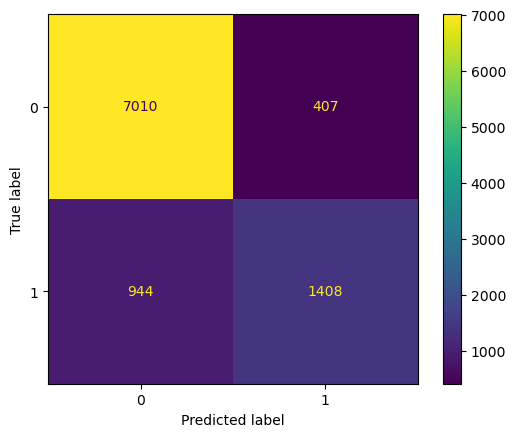

In [21]:
#it is possible to plot the confusion matrix 
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
disp.plot()
plt.show()

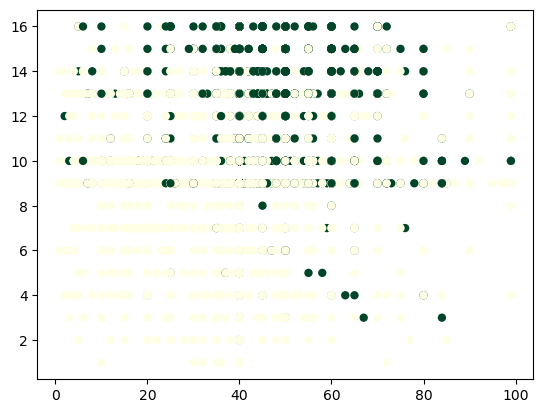

In [22]:
from sklearn.datasets import make_blobs
plt.scatter(test_set.iloc[:, 5].values, test_set.iloc[:, 2].values, c=test_label.values, s=25, cmap='YlGn');

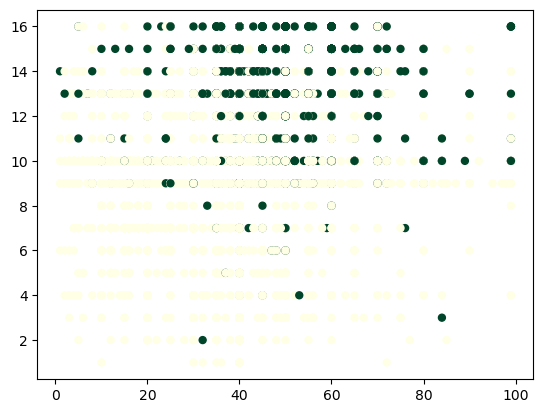

In [27]:
plt.scatter(test_set.iloc[:, 5].values, test_set.iloc[:, 2].values, c=test_pred_dt, s=25, cmap='YlGn');

# Classification with Naive Bayes
Bayes’ Theorem provides a way that we can calculate the probability of a piece of data belonging to a given class, given our prior knowledge. Bayes’ Theorem is stated as:

P(class|data) = (P(data|class) * P(class)) / P(data)
Where P(class|data) is the probability of class given the provided data.

In [28]:
#import, define and fit the model
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(train_set, train_label)

#predict on the test set
test_pred_gnb = gnb.predict(test_set)

In [29]:
#compute the performance of the model
report_scores(test_label,test_pred_gnb)

              precision    recall  f1-score   support

        <=50       0.81      0.95      0.88      7417
         >50       0.66      0.31      0.42      2352

    accuracy                           0.79      9769
   macro avg       0.73      0.63      0.65      9769
weighted avg       0.78      0.79      0.77      9769



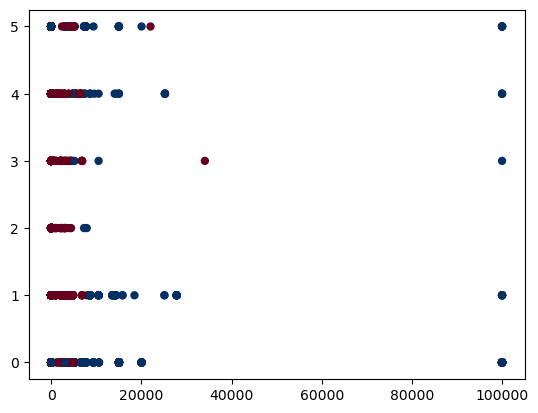

In [30]:
from sklearn.datasets import make_blobs
plt.scatter(test_set.iloc[:, 3].values, test_set.iloc[:, 6].values, c=test_label.values, s=25, cmap='RdBu');

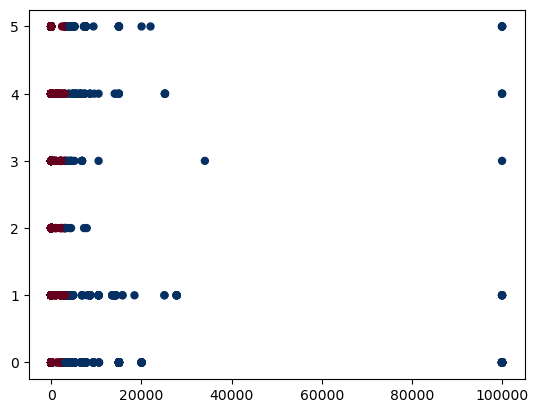

In [31]:
plt.scatter(test_set.iloc[:, 3].values, test_set.iloc[:, 6].values, c=test_pred_gnb, s=25, cmap='RdBu');

# Classification with Random Forest

In [32]:
#define and fit a random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=30, 
                             criterion='gini',
                             max_features=3,
                             max_depth=4, 
                             min_samples_split=2,
                             min_samples_leaf=8,
                             bootstrap=True) 
rf = rf.fit(train_set, train_label)

In [33]:
#prediction on the test test
test_pred_rf = rf.predict(test_set)

In [34]:
#compute the performance of the model
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

        <=50       0.85      0.98      0.91      7417
         >50       0.87      0.44      0.59      2352

    accuracy                           0.85      9769
   macro avg       0.86      0.71      0.75      9769
weighted avg       0.85      0.85      0.83      9769



### Grid search for parameter setting 

In [35]:
#to find the best set of parameter setting, we can run a grid search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

#define the parameters' values you want to try
param_dist = {"max_depth": [2,3,5,6,7,10,12,None],
              "max_features": sp_randint(1, len(train_set.iloc[0]) + 1),
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', None, {0: 0.3, 1: 0.7}]}
#define the number of iters
n_iter_search = 50
#define the model
clf = RandomForestClassifier(n_estimators=30)
#define the grid search
grid_search = RandomizedSearchCV(clf, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search.fit(train_set, train_label)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30), n_iter=50,
                   n_jobs=10,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced', None,
                                                         {0: 0.3, 1: 0.7}],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 5, 6, 7, 10, 12,
                                                      None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002186A143220>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002186A143EE0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002186A078D90>},
                   scoring=make_scorer(accuracy_score))

In [40]:
print('Best setting parameters ', grid_search.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0], 
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 7, 'min_samples_leaf': 15, 'min_samples_split': 36}
Mean and std of this setting  0.8516142553374358 0.005629134933102954


In [41]:
rf = RandomForestClassifier(n_estimators=30, 
                             criterion='gini',
                             max_features=7,
                             max_depth=5, 
                             min_samples_split=36,
                             min_samples_leaf=15,
                             bootstrap=False) 
rf = rf.fit(train_set, train_label)

In [42]:
#prediction on the test test
test_pred_rf = rf.predict(test_set)

In [43]:
#compute the performance of the model
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

        <=50       0.87      0.96      0.91      7417
         >50       0.80      0.55      0.65      2352

    accuracy                           0.86      9769
   macro avg       0.83      0.75      0.78      9769
weighted avg       0.85      0.86      0.85      9769



#### We can try to improve the performance by using class weights

In [44]:
class_weights = {0: 0.35, 1:0.65}
rf = RandomForestClassifier(n_estimators=30, 
                             criterion='gini',
                             max_features=8,
                             max_depth=6, 
                             min_samples_split=32,
                             min_samples_leaf=10,
                             bootstrap=False,
                             class_weight= class_weights) 
rf = rf.fit(train_set, train_label)

In [45]:
#prediction on the test test
test_pred_rf = rf.predict(test_set)

#### In this way we obtain a better performance in terms of recall for the class 1, but we loose a bit on the recall of class 0.

In [46]:
#compute the performance of the model
print(classification_report(test_label, 
                            test_pred_rf, 
                            target_names=['<=50', '>50']))

              precision    recall  f1-score   support

        <=50       0.93      0.84      0.88      7417
         >50       0.61      0.79      0.69      2352

    accuracy                           0.83      9769
   macro avg       0.77      0.82      0.79      9769
weighted avg       0.85      0.83      0.84      9769



# AdaBoost

In [48]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()
clf.fit(train_set, train_label)

AdaBoostClassifier()

In [49]:
test_pred_clf = clf.predict(test_set)
print(classification_report(test_label, 
                            test_pred_clf, 
                            target_names=['<=50', '>50']))

              precision    recall  f1-score   support

        <=50       0.88      0.95      0.91      7417
         >50       0.78      0.60      0.68      2352

    accuracy                           0.86      9769
   macro avg       0.83      0.77      0.79      9769
weighted avg       0.86      0.86      0.86      9769



Adaboost has many parameters, we can select the base classifier, which can be a DecisionTree, a Logistic Regression and so on, we can select the number of estimators and the learning rate.

In [51]:
base = tree.DecisionTreeClassifier(max_depth=5)
clf = AdaBoostClassifier(estimator=base, n_estimators=200, learning_rate=0.1)
clf.fit(train_set, train_label)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5),
                   learning_rate=0.1, n_estimators=200)

In [52]:
test_pred_clf = clf.predict(test_set)
print(classification_report(test_label, 
                            test_pred_clf, 
                            target_names=['<=50', '>50']))

              precision    recall  f1-score   support

        <=50       0.89      0.94      0.92      7417
         >50       0.77      0.65      0.70      2352

    accuracy                           0.87      9769
   macro avg       0.83      0.79      0.81      9769
weighted avg       0.86      0.87      0.86      9769



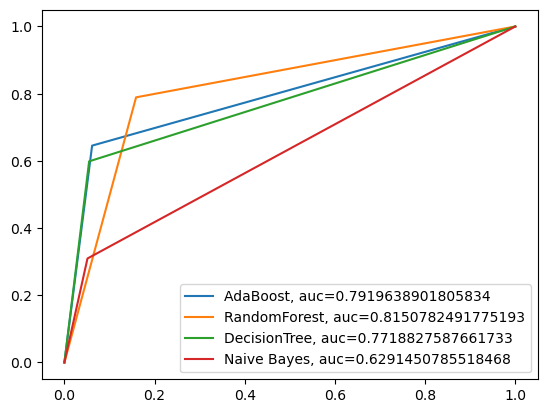

In [53]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

plt.figure(0).clf()

fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_clf)
auc = metrics.roc_auc_score(test_label, test_pred_clf)
plt.plot(fpr,tpr,label="AdaBoost, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_rf)
auc = metrics.roc_auc_score(test_label, test_pred_rf)
plt.plot(fpr,tpr,label="RandomForest, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_dt)
auc = metrics.roc_auc_score(test_label, test_pred_dt)
plt.plot(fpr,tpr,label="DecisionTree, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_gnb)
auc = metrics.roc_auc_score(test_label, test_pred_gnb)
plt.plot(fpr,tpr,label="Naive Bayes, auc="+str(auc))

plt.legend(loc=0)

# Classification with KNN

In [54]:
#drop the categorical features
train_set_no_cat = train_set.loc[:,~train_set.columns.str.contains('_num', case=False)] 
test_set_no_cat = test_set.loc[:,~test_set.columns.str.contains('_num', case=False)] 

In [55]:
from sklearn.neighbors import KNeighborsClassifier
#['auto', 'ball_tree', 'kd_tree', 'brute']
knn = KNeighborsClassifier(n_neighbors=2, algorithm='ball_tree', metric='minkowski').fit(train_set_no_cat, train_label)

In [56]:
#prediction on the test test
test_pred_knn = knn.predict(test_set_no_cat)

In [57]:
#compute the performance of the model
report_scores(test_label,test_pred_knn)

              precision    recall  f1-score   support

        <=50       0.80      0.95      0.87      7417
         >50       0.62      0.26      0.37      2352

    accuracy                           0.78      9769
   macro avg       0.71      0.61      0.62      9769
weighted avg       0.76      0.78      0.75      9769



# Classification with SVM

In [59]:
#linear,poly,rbf,sigmoid,precomputed
from sklearn.svm import SVC
svm = SVC(kernel='sigmoid', C=0.5, gamma='scale', probability=True)
svm.fit(train_set, train_label)

SVC(C=0.5, kernel='sigmoid', probability=True)

In [60]:
#prediction on the test test
test_pred_proba_svm = svm.predict_proba(test_set)

In [61]:
test_pred_proba_svm

array([[0.76513844, 0.23486156],
       [0.75743545, 0.24256455],
       [0.76473486, 0.23526514],
       ...,
       [0.75098447, 0.24901553],
       [0.75863723, 0.24136277],
       [0.76435854, 0.23564146]])

In [62]:
test_pred_svm = svm.predict(test_set)

In [63]:
test_pred_svm

array([1, 0, 0, ..., 0, 0, 0])

In [64]:
#compute the performance of the model
print(classification_report(test_label, 
                            test_pred_svm, 
                            target_names=['<=50', '>50']))

              precision    recall  f1-score   support

        <=50       0.77      0.78      0.77      7417
         >50       0.26      0.25      0.26      2352

    accuracy                           0.65      9769
   macro avg       0.51      0.51      0.51      9769
weighted avg       0.65      0.65      0.65      9769



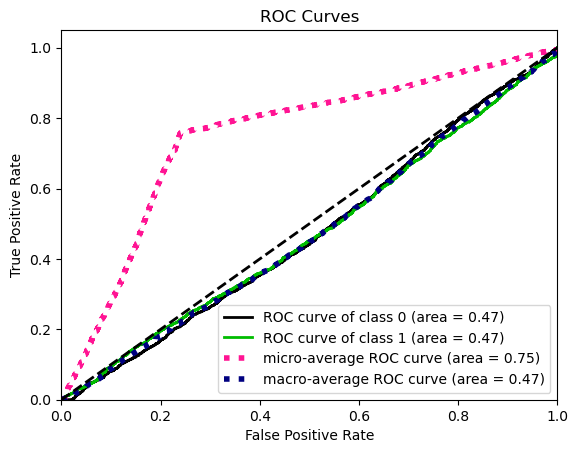

In [68]:
import scikitplot as skplt
import matplotlib.pyplot as plt
test_pred_proba = svm.predict_proba(test_set)
skplt.metrics.plot_roc(test_label.values, test_pred_proba)
plt.show()

# Classification with rule based 

#### There are several rule-based methods. One of the most popular is RIPPER. To use it, you have to install it using !pip install wittgenstein. The documentation of this method can be found in https://github.com/imoscovitz/wittgenstein

In [69]:
#we run a grid search to find the best configuration of parameters' values
# prune_size: change the grow/prune proportion
# k: the number of optimization runs

import wittgenstein as lw
ripper = lw.RIPPER()
param_grid = {"prune_size": [0.5, 0.6], "k": [1, 3, 5]}
grid_search = GridSearchCV(estimator=ripper, param_grid=param_grid)
grid_search.fit(train_set, train_label)

GridSearchCV(estimator=<RIPPER(dl_allowance=64, max_rule_conds=None, random_state=None, n_discretize_bins=10, k=2, alpha=1.0, max_rules=None, max_total_conds=None, prune_size=0.33, verbosity=0)>,
             param_grid={'k': [1, 3, 5], 'prune_size': [0.5, 0.6]})

In [70]:
print('Best parameters setting ', grid_search.cv_results_['params'][0])

Best parameters setting  {'k': 1, 'prune_size': 0.5}


In [71]:
#define and fit the rule-based model
#this function requires only one dataset with the labels. 
#To do so, we concatenate the train_set and the train_label
import wittgenstein as lw
ripper = lw.RIPPER(k=1, prune_size=0.50)
datas = pd.concat([train_set, train_label], axis=1)
ripper.fit(datas, class_feat='label_num', pos_class=1)

In [72]:
#in this case the model is a set of rules
ripper.out_model()

[[marital-status_num=2 ^ education-num=>13.0 ^ occupation_num=3.0-4.0 ^ hours-per-week=48.0-55.0 ^ relationship_num=0 ^ native-country_num=36.0-39.0 ^ workclass_num=4] V
[marital-status_num=2 ^ education-num=11.0-13.0 ^ occupation_num=3.0-4.0 ^ hours-per-week=48.0-55.0 ^ fnlwgt=106377.0-130765.7] V
[marital-status_num=2 ^ education-num=11.0-13.0 ^ occupation_num=3.0-4.0 ^ capital-loss=1742.4-2178.0] V
[marital-status_num=2 ^ education-num=11.0-13.0 ^ occupation_num=3.0-4.0 ^ hours-per-week=48.0-55.0 ^ workclass_num=4] V
[marital-status_num=2 ^ education-num=>13.0 ^ occupation_num=8.0-10.0 ^ capital-loss=1742.4-2178.0] V
[marital-status_num=2 ^ education-num=>13.0 ^ capital-gain=9999.9-19999.8] V
[marital-status_num=2 ^ education-num=11.0-13.0 ^ occupation_num=3.0-4.0 ^ capital-gain=9999.9-19999.8] V
[marital-status_num=2 ^ occupation_num=8.0-10.0 ^ education-num=>13.0 ^ age=37.0-41.0 ^ hours-per-week=48.0-55.0] V
[marital-status_num=2 ^ education-num=11.0-13.0 ^ occupation_num=3.0-4.0 

In [73]:
ripper.predict(test_set)

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 False

In [74]:
#evaluation of the performance of the classifier
from sklearn.metrics import precision_score, recall_score
print('Accuracy ', ripper.score(test_set, test_label))
print('Precision ', ripper.score(test_set, test_label, precision_score))
print('Recall ', ripper.score(test_set, test_label, recall_score))

Accuracy  0.8263895997543249
Precision  0.7146596858638743
Recall  0.4642857142857143


In [75]:
#with rule based classifiers it is possible to extract the reasons for the prediction.
#only for the positive predictions
ripper.predict(test_set[:15], give_reasons=True)

([False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True],
 [[],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [<Rule [marital-status_num=2^education-num=11.0-13.0^occupation_num=11.0-12.0]>,
   <Rule [marital-status_num=2^education-num=11.0-13.0]>]])

# Classification with neural network

#### Another possibility is to employ neural networks. Even if they are more suited for time series, text or images, we can try a simple example just to see how they work. We define, using keras (under tensorflow), a simple feed forward nn and then we fit it. Note that in this case the nn is a Sequential model, composed of layers. We can add as many layers as we want, but in the first one we need to define the input structure.  

Let's start with a simple neural network composed by 1 hidden layer.

In [12]:
import tensorflow as tf
import numpy as np
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(1, 13)),
  tf.keras.layers.Dense(32, activation='sigmoid'),  
  tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adamax',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [13]:
y_train = np.asarray(train_label).astype('float32').reshape((-1,1))
x_train = np.reshape(train_set.values, (22792, 1, 13))
history = model.fit(x_train, y_train,
                    epochs=80,
                    batch_size=512,
                    validation_split=0.2)

Epoch 1/80
36/36 [==============================] - 2s 15ms/step - loss: 0.5715 - accuracy: 0.2391 - val_loss: 0.5252 - val_accuracy: 0.2479
Epoch 2/80
36/36 [==============================] - 0s 7ms/step - loss: 0.4884 - accuracy: 0.2391 - val_loss: 0.4363 - val_accuracy: 0.2479
Epoch 3/80
36/36 [==============================] - 0s 6ms/step - loss: 0.3940 - accuracy: 0.2391 - val_loss: 0.3409 - val_accuracy: 0.2479
Epoch 4/80
36/36 [==============================] - 0s 6ms/step - loss: 0.3023 - accuracy: 0.2389 - val_loss: 0.2634 - val_accuracy: 0.2406
Epoch 5/80
36/36 [==============================] - 0s 5ms/step - loss: 0.2397 - accuracy: 0.6300 - val_loss: 0.2204 - val_accuracy: 0.7530
Epoch 6/80
36/36 [==============================] - 0s 5ms/step - loss: 0.2083 - accuracy: 0.7620 - val_loss: 0.2015 - val_accuracy: 0.7524
Epoch 7/80
36/36 [==============================] - 0s 5ms/step - loss: 0.1944 - accuracy: 0.7616 - val_loss: 0.1933 - val_accuracy: 0.7524
Epoch 8/80
36/36 [=

36/36 [==============================] - 0s 5ms/step - loss: 0.1807 - accuracy: 0.7625 - val_loss: 0.1850 - val_accuracy: 0.7541
Epoch 60/80
36/36 [==============================] - 0s 5ms/step - loss: 0.1807 - accuracy: 0.7625 - val_loss: 0.1850 - val_accuracy: 0.7541
Epoch 61/80
36/36 [==============================] - 0s 5ms/step - loss: 0.1807 - accuracy: 0.7625 - val_loss: 0.1850 - val_accuracy: 0.7541
Epoch 62/80
36/36 [==============================] - 0s 5ms/step - loss: 0.1806 - accuracy: 0.7625 - val_loss: 0.1849 - val_accuracy: 0.7541
Epoch 63/80
36/36 [==============================] - 0s 6ms/step - loss: 0.1806 - accuracy: 0.7625 - val_loss: 0.1849 - val_accuracy: 0.7541
Epoch 64/80
36/36 [==============================] - 0s 8ms/step - loss: 0.1806 - accuracy: 0.7625 - val_loss: 0.1849 - val_accuracy: 0.7541
Epoch 65/80
36/36 [==============================] - 0s 7ms/step - loss: 0.1806 - accuracy: 0.7625 - val_loss: 0.1849 - val_accuracy: 0.7541
Epoch 66/80
36/36 [======

In [87]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 13)                0         
                                                                 
 dense (Dense)               (None, 32)                448       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 481 (1.88 KB)
Trainable params: 481 (1.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


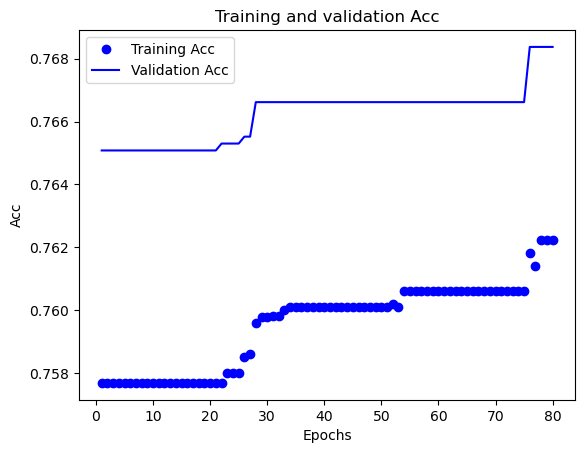

In [89]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [90]:
x_test = np.reshape(test_set.values, (len(test_set), 1, 13))
test_pred_nn = (model.predict(x_test) > 0.5).astype("int32")

306/306 [==============================] - 1s 2ms/step


In [91]:
print(test_pred_nn)
print(len(test_pred_nn))
print(len(test_set))

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
9769
9769


In [92]:
report_scores(test_label, test_pred_nn)

              precision    recall  f1-score   support

        <=50       0.76      1.00      0.87      7417
         >50       0.98      0.02      0.04      2352

    accuracy                           0.76      9769
   macro avg       0.87      0.51      0.45      9769
weighted avg       0.81      0.76      0.67      9769



Since the first neural network is not performing well, we can modify it, by adding hidden layers and dropout. 

In [93]:
import tensorflow as tf
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(1, 13)),
  tf.keras.layers.Dense(256, activation='sigmoid'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(256, activation='sigmoid'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adamax',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [94]:
y_train = np.asarray(train_label).astype('float32').reshape((-1,1))
history = model.fit(x_train, y_train,
                    epochs=80,
                    batch_size=256,
                    validation_split=0.2)

Epoch 1/80
72/72 [==============================] - 2s 12ms/step - loss: 0.1785 - accuracy: 0.7645 - val_loss: 0.1663 - val_accuracy: 0.7866
Epoch 2/80
72/72 [==============================] - 1s 12ms/step - loss: 0.1661 - accuracy: 0.7893 - val_loss: 0.1615 - val_accuracy: 0.7951
Epoch 3/80
72/72 [==============================] - 1s 8ms/step - loss: 0.1641 - accuracy: 0.7913 - val_loss: 0.1608 - val_accuracy: 0.7953
Epoch 4/80
72/72 [==============================] - 1s 8ms/step - loss: 0.1626 - accuracy: 0.7925 - val_loss: 0.1606 - val_accuracy: 0.7938
Epoch 5/80
72/72 [==============================] - 1s 8ms/step - loss: 0.1647 - accuracy: 0.7915 - val_loss: 0.1644 - val_accuracy: 0.7940
Epoch 6/80
72/72 [==============================] - 1s 8ms/step - loss: 0.1671 - accuracy: 0.7912 - val_loss: 0.1637 - val_accuracy: 0.7951
Epoch 7/80
72/72 [==============================] - 1s 8ms/step - loss: 0.1661 - accuracy: 0.7913 - val_loss: 0.1625 - val_accuracy: 0.7951
Epoch 8/80
72/72 [

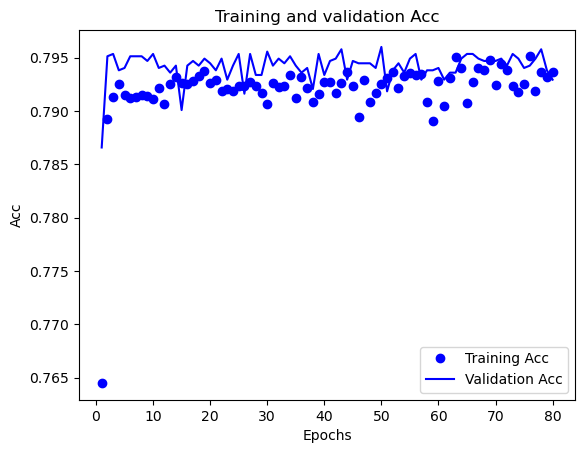

In [96]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [97]:
test_pred_nn = (model.predict(x_test) > 0.5).astype("int32")

306/306 [==============================] - 1s 3ms/step


In [98]:
test_pred_nn

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [99]:
#compute the performance of the model
report_scores(test_label, test_pred_nn)

              precision    recall  f1-score   support

        <=50       0.79      0.99      0.88      7417
         >50       0.83      0.18      0.30      2352

    accuracy                           0.79      9769
   macro avg       0.81      0.58      0.59      9769
weighted avg       0.80      0.79      0.74      9769

